## Prechecks

In [8]:
import torch
from timm import create_model

### Check output shape from pretrained model

In [9]:
m = create_model('densenet121', pretrained=True, num_classes=0, global_pool='avg')
o = m(torch.randn(2, 3, 224, 224))
o = m.forward_features(torch.randn(2, 3, 224, 224))
print(f"Feature shape:{o.shape}")

Feature shape:torch.Size([2, 1024, 7, 7])


### Test if using MPS backend

In [22]:
if __name__ == '__main__':
  # Check if MPS backend is available in PyTorch
  if torch.backends.mps.is_available():
      # Create a vector on the MPS device
      x = torch.ones(1, device='mps')
      print(x)
  else:
      print('MPS device not found.')

tensor([1.], device='mps:0')


# Model Pipeline

**Sources:**
- [Training loop](https://machinelearningmastery.com/creating-a-training-loop-for-pytorch-models/)
- [Freezing layers](https://stackoverflow.com/questions/62523912/freeze-certain-layers-of-an-existing-model-in-pytorch)
- [timm](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055)
- [Image transforms](https://pytorch.org/vision/stable/transforms.html)
- [Transfer learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/)
- [MPS backend](https://stackoverflow.com/questions/77226100/snn-that-works-on-cpu-throws-mismatched-tensor-types-in-nnpack-convolutionoutpu)
- [W&B Tutorial](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb#scrollTo=rmPkh7VRXdrr)

### Import libraries

In [1]:
import torch
import random
import wandb
import os.path
import numpy as np
import torch.nn as nn
import torch.optim as optim
import helpers.fc_models as fc_models
from timm import create_model
from helpers.ImageFolderPathsIndices import get_dataloader
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm

# Fix seed for reproducible results
np.random.seed(2)
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(2)
random.seed(2)

### Define the model pipeline with WandB

In [2]:
def model_pipeline(project, hyperparameters):
    with wandb.init(project=project, config=hyperparameters):
        config = wandb.config

        fc_model, feat_extractor, train_loader, valid_loader, test_loader, criterion, optimizer = make(config)
        print(config.fc_model, config.feat_extractor)
        print(fc_model)
        
        # and use them to train the model
        train(fc_model, feat_extractor, train_loader, valid_loader, criterion, optimizer, config)

        # and test its final performance
        return test(fc_model, feat_extractor, test_loader, config)

### Handles initializing model for experiment

In [3]:
def make(config):
    # Create dataset loaders
    # NOTE: returns a tuple with form (index, image, label, file_path)
    train_loader = get_dataloader(config.dataset, config.batch_size, 'train', config.train_aug, config.normalize)
    valid_loader = get_dataloader(config.dataset, config.batch_size, 'valid', config.train_aug, config.normalize)
    test_loader = get_dataloader(config.dataset, config.batch_size, 'test', config.train_aug, config.normalize)

    # Set feature size and if valid feature extractor provided
    feat_extractor_names = ['resnet50d', 'mobilenetv2_100', 'densenet121']
    if config.feat_extractor == 'resnet50d':
        fc1_in = 2048
    elif config.feat_extractor == 'mobilenetv2_100':
        fc1_in = 1280
    elif config.feat_extractor == 'densenet121':
        fc1_in = 1024
    else:
        raise ValueError(f"`feat_extractor` field of config should be one of {feat_extractor_names}")
    
    # Load pretrained model as feature extractor
    feat_extractor = create_model(config.feat_extractor, pretrained=True, global_pool='avg', num_classes=0)
    for param in feat_extractor.parameters():
        param.requires_grad = False
    feat_extractor.eval()
    feat_extractor.to(config.device)

    # Set fc model
    if config.fc_model == 'lin1':
        fc_model = fc_models.Lin1(fc1_in, config.output)
    elif config.fc_model == 'lin2':
        fc_model = fc_models.Lin2(fc1_in, config.fc2_in, config.output, config.dropout_rate)
    elif config.fc_model == 'lin3':
        fc_model = fc_models.Lin3(fc1_in, config.fc2_in, config.fc3_in, config.output, config.dropout_rate)
    else:
        raise ValueError(f'`fc_model` field of config should be one of {fc_models.FC_NAMES}')
    
    # Send model to device
    fc_model.to(config.device)

    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(fc_model.parameters(), lr=config.learning_rate)
    
    return fc_model, feat_extractor, train_loader, valid_loader, test_loader, criterion, optimizer

## Training loop

In [4]:
def train(model, feat_extractor, train_loader, valid_loader, criterion, optimizer, config):
    # Tell wandb to watch the model gradients and weights
    wandb.watch(model, criterion, log="all", log_freq=10)

    for epoch in tqdm(range(config.epochs)):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for _, images, labels, _ in train_loader:
            # Send data to the same device as the model
            images, labels = images.to(config.device), labels.to(config.device)
            # Run through feature extractor (pre-trained model)
            features = feat_extractor(images)
            # Calculate loss and number of correct predictions
            loss, correct = train_batch(features, labels, model, optimizer, criterion)
            # Update counts
            train_loss += loss
            train_correct += correct
        # Log training loss and accuracy
        train_log(train_loss, train_correct / len(train_loader.dataset), epoch)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        for _, images, labels, _ in valid_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            features = feat_extractor(images)
            loss, correct = val_batch(features, labels, model, criterion)
            val_loss += loss
            val_correct += correct
        val_log(val_loss, val_correct / len(valid_loader.dataset), epoch)
    
    if config.save_as == 'pth':
        torch.save(model.state_dict(), os.path.join('weights', f"{config.feat_extractor}_{config.fc_model}.pth"))


In [5]:
def train_batch(images, labels, model, optimizer, criterion):
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate number of correct predictions for batch
    _,predicted = torch.max(outputs.data, 1)

    correct_train = (predicted == labels).sum().item()
    # Return loss and number of correct predictions
    return loss.item(), correct_train

def val_batch(images, labels, model, criterion):
    outputs = model(images)
    # Calculate number of correct predictions for batch
    _,predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)
    correct_val = (predicted == labels).sum().item()
    return loss, correct_val

def train_log(loss, acc, epoch):
    # Log loss and accuracy to wandb
    wandb.log({"train/loss": loss, "train/accuracy": acc}, step=epoch)
    print(f"Training Epoch {epoch}: Loss = {loss}, Accuracy = {acc:%}")

def val_log(loss, acc, epoch):
    # Log loss and accuracy to wandb
    wandb.log({"validation/loss": loss, "validation/accuracy": acc}, step=epoch)
    print(f"Validation Epoch {epoch}: Loss = {loss}, Accuracy = {acc:%}")

## Testing

In [6]:
def test(model, feat_extractor, test_loader, config):
    if config.save_as == 'pth':
        model.load_state_dict(torch.load(os.path.join('weights', f"{config.feat_extractor}_{config.fc_model}.pth")))
    feat_extractor.to("cpu")
    model.to("cpu")
    model.eval()
    
    true_labels = torch.zeros(len(test_loader.dataset)).long()
    pred_labels = torch.zeros(len(test_loader.dataset)).long()
    ptr = 0
    
    with torch.no_grad():
        correct, total = 0, 0
        for batch, (indices, images, labels, paths) in enumerate(test_loader):
            features = feat_extractor(images)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            print(f"Batch {batch}: Accuracy = {accuracy_score(labels, predicted):%}, " +
                  f"Recall = {recall_score(labels, predicted, zero_division=0):%}, Precision = {precision_score(labels, predicted):%}")
            
            # Record labels and predictions
            inds = ptr + torch.arange(labels.shape[0])
            true_labels.index_copy_(0, inds, labels)
            pred_labels.index_copy_(0, inds, predicted)
            ptr += labels.shape[0]

        # Log avg test accuracy
        wandb.log({"test/accuracy": accuracy_score(true_labels, pred_labels)})
        # Display confusion matrix for run
        cm = confusion_matrix(true_labels, pred_labels)
        return cm

## Average Metrics from Multiple Training Runs

In [7]:
def ensemble(project, config_dict, itr):
    cm = np.zeros((2,2))
    for i in range(itr):
        cm += model_pipeline(project, config_dict)
    cm /= itr
    return cm

# ResNet50 + 2 fully connected layers

### Hyperparameter configuration

In [8]:
config_dict = dict(
    learning_rate = 0.003,
    epochs = 20,
    batch_size = 100,
    feat_extractor = "resnet50d",
    fc_model = "lin1",
    normalize = "ImageNet",
    fc2_in = 200,
    output = 2,
    dropout_rate = 0.5,
    dataset = "SC-2000v2",
    train_aug = True,
    device = "mps",
    save_as = 'pth'
)

### Get confusion matrix results averaged across 5 runs

In [9]:
cm = ensemble('resnet50d-sc2000', config_dict, 5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: livsworld (shenderm). Use `wandb login --relogin` to force relogin


lin1 resnet50d
Lin1(
  (fc1): Linear(in_features=2048, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 8.89033654332161, Accuracy = 69.316689%
Validation Epoch 0: Loss = 1.7965896129608154, Accuracy = 82.528736%
Training Epoch 1: Loss = 7.124952644109726, Accuracy = 78.186597%
Validation Epoch 1: Loss = 1.6638996601104736, Accuracy = 84.137931%
Training Epoch 2: Loss = 7.148341715335846, Accuracy = 78.580815%
Validation Epoch 2: Loss = 1.7711327075958252, Accuracy = 84.137931%
Training Epoch 3: Loss = 6.546598479151726, Accuracy = 79.632063%
Validation Epoch 3: Loss = 1.8265947103500366, Accuracy = 81.149425%
Training Epoch 4: Loss = 6.6331357061862946, Accuracy = 79.763469%
Validation Epoch 4: Loss = 1.9050168991088867, Accuracy = 82.068966%
Training Epoch 5: Loss = 7.114650726318359, Accuracy = 78.055191%
Validation Epoch 5: Loss = 1.719172716140747, Accuracy = 83.678161%
Training Epoch 6: Loss = 6.683858245611191, Accuracy = 80.223390%
Validation Epoch 6: Loss = 1.800154447555542, Accuracy = 83.218391%
Training Epoch 7: Loss = 6.822438538074493, Accuracy = 79

test/accuracy,▁
train/accuracy,▁▅▅▆▆▅▆▆▇▇▆▇▇▇█▇▇██▇
train/loss,█▄▄▃▃▄▃▃▂▂▃▂▁▂▂▂▂▂▁▂
validation/accuracy,▄▇▇▂▄▆▅▇▇▆▅█▁▇▇▇▆▇▃▅
validation/loss,▃▁▃▃▄▂▃▁▂▂▃▂▇▄▂▁▄▄█▄
test/accuracy,0.87324
train/accuracy,0.82063
train/loss,6.1004
validation/accuracy,0.83218
validation/loss,1.90769


lin1 resnet50d
Lin1(
  (fc1): Linear(in_features=2048, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 9.043067306280136, Accuracy = 68.462549%
Validation Epoch 0: Loss = 1.9370949268341064, Accuracy = 79.540230%
Training Epoch 1: Loss = 7.326999187469482, Accuracy = 78.843627%
Validation Epoch 1: Loss = 1.8184881210327148, Accuracy = 81.149425%
Training Epoch 2: Loss = 7.060982584953308, Accuracy = 80.091984%
Validation Epoch 2: Loss = 1.788508415222168, Accuracy = 81.839080%
Training Epoch 3: Loss = 6.647042393684387, Accuracy = 80.814717%
Validation Epoch 3: Loss = 1.7853724956512451, Accuracy = 81.609195%
Training Epoch 4: Loss = 6.826353996992111, Accuracy = 80.289093%
Validation Epoch 4: Loss = 1.8039623498916626, Accuracy = 83.448276%
Training Epoch 5: Loss = 6.605113178491592, Accuracy = 80.814717%
Validation Epoch 5: Loss = 1.7085862159729004, Accuracy = 84.367816%
Training Epoch 6: Loss = 6.4295973777771, Accuracy = 80.946124%
Validation Epoch 6: Loss = 1.6820552349090576, Accuracy = 83.678161%
Training Epoch 7: Loss = 6.265702039003372, Accuracy = 81.

test/accuracy,▁
train/accuracy,▁▆▆▇▇▇▇▇▇█▇▇▇▇███▇▇█
train/loss,█▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▂▂▁
validation/accuracy,▁▃▄▄▆▇▆▇▆▇█▇▆█▆▆█▄▅▇
validation/loss,█▅▅▄▅▃▂▂▅▃▄▄▅▁▇▄▄▅▄▃
test/accuracy,0.87324
train/accuracy,0.82786
train/loss,6.02037
validation/accuracy,0.84138
validation/loss,1.73794


lin1 resnet50d
Lin1(
  (fc1): Linear(in_features=2048, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 8.297960638999939, Accuracy = 72.996058%
Validation Epoch 0: Loss = 1.949370265007019, Accuracy = 80.919540%
Training Epoch 1: Loss = 6.926238864660263, Accuracy = 78.580815%
Validation Epoch 1: Loss = 1.7402915954589844, Accuracy = 82.528736%
Training Epoch 2: Loss = 6.987757444381714, Accuracy = 78.055191%
Validation Epoch 2: Loss = 1.7332689762115479, Accuracy = 84.137931%
Training Epoch 3: Loss = 6.476653680205345, Accuracy = 80.749014%
Validation Epoch 3: Loss = 1.8385009765625, Accuracy = 80.919540%
Training Epoch 4: Loss = 6.681154310703278, Accuracy = 80.157687%
Validation Epoch 4: Loss = 1.8514593839645386, Accuracy = 82.988506%
Training Epoch 5: Loss = 6.678264290094376, Accuracy = 79.697766%
Validation Epoch 5: Loss = 1.791029453277588, Accuracy = 83.448276%
Training Epoch 6: Loss = 6.658723056316376, Accuracy = 80.814717%
Validation Epoch 6: Loss = 1.7941287755966187, Accuracy = 82.988506%
Training Epoch 7: Loss = 6.508985131978989, Accuracy = 81.40

test/accuracy,▁
train/accuracy,▁▅▄▆▆▅▆▇▇▆▇▇█▇▇██▇▇▆
train/loss,█▄▄▃▃▃▃▃▃▂▃▂▁▂▁▂▁▃▂▂
validation/accuracy,▃▆█▃▆▇▆▇▆▇▆▇█▆▆▇█▁▃▆
validation/loss,▆▂▂▄▄▃▃▃▄▃▄▃▂▃▂▃▁▅█▃
test/accuracy,0.83568
train/accuracy,0.80618
train/loss,6.39364
validation/accuracy,0.82529
validation/loss,1.76693


lin1 resnet50d
Lin1(
  (fc1): Linear(in_features=2048, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 8.240042805671692, Accuracy = 73.455979%
Validation Epoch 0: Loss = 1.7344160079956055, Accuracy = 84.137931%
Training Epoch 1: Loss = 7.259764939546585, Accuracy = 78.120894%
Validation Epoch 1: Loss = 1.6838597059249878, Accuracy = 84.597701%
Training Epoch 2: Loss = 7.03551921248436, Accuracy = 78.975033%
Validation Epoch 2: Loss = 1.6710611581802368, Accuracy = 85.517241%
Training Epoch 3: Loss = 6.530404210090637, Accuracy = 81.340342%
Validation Epoch 3: Loss = 1.8038153648376465, Accuracy = 83.678161%
Training Epoch 4: Loss = 6.3762262761592865, Accuracy = 80.617608%
Validation Epoch 4: Loss = 1.8351906538009644, Accuracy = 84.137931%
Training Epoch 5: Loss = 6.802680432796478, Accuracy = 80.289093%
Validation Epoch 5: Loss = 1.7598122358322144, Accuracy = 84.827586%
Training Epoch 6: Loss = 6.49092772603035, Accuracy = 80.946124%
Validation Epoch 6: Loss = 1.771106243133545, Accuracy = 84.827586%
Training Epoch 7: Loss = 6.940590411424637, Accuracy = 80

test/accuracy,▁
train/accuracy,▁▄▅▆▆▆▆▅▅█▇▇▇▇███▇██
train/loss,█▅▅▃▃▄▃▄▄▂▃▃▂▂▃▂▂▂▁▂
validation/accuracy,▄▅▇▃▄▆▆▁▇▃▇█▄▇▆▇▄▃▅▄
validation/loss,▂▁▁▄▄▃▃█▃▃▂▂▄▄▃▄▅▆▃▄
test/accuracy,0.85446
train/accuracy,0.83837
train/loss,5.93356
validation/accuracy,0.83908
validation/loss,1.78904


lin1 resnet50d
Lin1(
  (fc1): Linear(in_features=2048, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 8.182654589414597, Accuracy = 73.915900%
Validation Epoch 0: Loss = 2.0045454502105713, Accuracy = 82.068966%
Training Epoch 1: Loss = 7.7254137098789215, Accuracy = 76.675427%
Validation Epoch 1: Loss = 1.9041498899459839, Accuracy = 80.919540%
Training Epoch 2: Loss = 6.853832989931107, Accuracy = 79.960578%
Validation Epoch 2: Loss = 1.711290717124939, Accuracy = 83.908046%
Training Epoch 3: Loss = 6.562959522008896, Accuracy = 80.946124%
Validation Epoch 3: Loss = 1.7770066261291504, Accuracy = 82.298851%
Training Epoch 4: Loss = 6.3704634308815, Accuracy = 80.617608%
Validation Epoch 4: Loss = 1.781402587890625, Accuracy = 81.839080%
Training Epoch 5: Loss = 6.610250324010849, Accuracy = 81.406045%
Validation Epoch 5: Loss = 1.7247364521026611, Accuracy = 82.068966%
Training Epoch 6: Loss = 6.651069939136505, Accuracy = 80.157687%
Validation Epoch 6: Loss = 1.7511229515075684, Accuracy = 81.839080%
Training Epoch 7: Loss = 6.303075969219208, Accuracy = 81.

test/accuracy,▁
train/accuracy,▁▃▅▅▅▆▅▆▇▅▇▇▇▆▆▇▇█▇▇
train/loss,█▇▄▃▃▃▃▂▂▃▂▂▁▂▂▃▁▁▂▂
validation/accuracy,▃▁▆▃▂▃▂▃▃▅█▆█▆▆▆▃▅█▄
validation/loss,█▆▃▄▄▃▃▂▂▆▂▂▁▂▃▄█▃▁▃
test/accuracy,0.84977
train/accuracy,0.83114
train/loss,6.02489
validation/accuracy,0.82989
validation/loss,1.72383


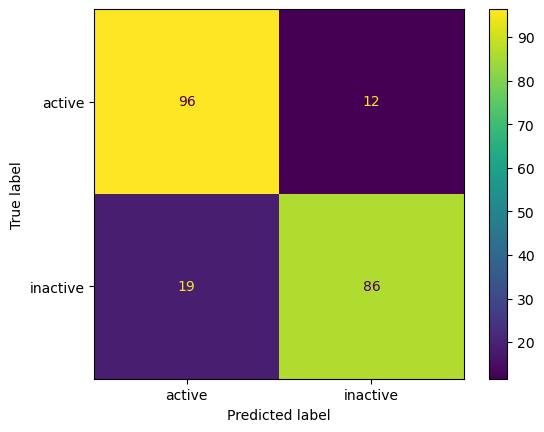

In [10]:
display = ConfusionMatrixDisplay(cm, display_labels=["active", "inactive"])
display.plot()

### Run pipeline

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: livsworld (shenderm). Use `wandb login --relogin` to force relogin


lin1 resnet50d
Lin1(
  (fc1): Linear(in_features=2048, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 8.89033654332161, Accuracy = 69.316689%
Validation Epoch 0: Loss = 1.7965896129608154, Accuracy = 82.528736%
Training Epoch 1: Loss = 7.124952644109726, Accuracy = 78.186597%
Validation Epoch 1: Loss = 1.6638996601104736, Accuracy = 84.137931%
Training Epoch 2: Loss = 7.148341715335846, Accuracy = 78.580815%
Validation Epoch 2: Loss = 1.7711327075958252, Accuracy = 84.137931%
Training Epoch 3: Loss = 6.546598479151726, Accuracy = 79.632063%
Validation Epoch 3: Loss = 1.8265947103500366, Accuracy = 81.149425%
Training Epoch 4: Loss = 6.6331357061862946, Accuracy = 79.763469%
Validation Epoch 4: Loss = 1.9050168991088867, Accuracy = 82.068966%
Training Epoch 5: Loss = 7.114650726318359, Accuracy = 78.055191%
Validation Epoch 5: Loss = 1.719172716140747, Accuracy = 83.678161%
Training Epoch 6: Loss = 6.683858245611191, Accuracy = 80.223390%
Validation Epoch 6: Loss = 1.800154447555542, Accuracy = 83.218391%
Training Epoch 7: Loss = 6.822438538074493, Accuracy = 79

test/accuracy,▁
train/accuracy,▁▅▅▆▆▅▆▆▇▇▆▇▇▇█▇▇██▇
train/loss,█▄▄▃▃▄▃▃▂▂▃▂▁▂▂▂▂▂▁▂
validation/accuracy,▄▇▇▂▄▆▅▇▇▆▅█▁▇▇▇▆▇▃▅
validation/loss,▃▁▃▃▄▂▃▁▂▂▃▂▇▄▂▁▄▄█▄
test/accuracy,0.87324
train/accuracy,0.82063
train/loss,6.1004
validation/accuracy,0.83218
validation/loss,1.90769


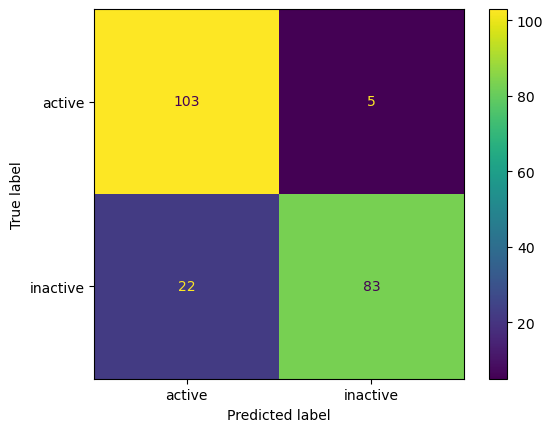

In [8]:
model_pipeline('resnet50d-sc2000', config_dict)

# MobileNetv2_100 + 2 fully connected layers

### Hyperparameter configuration

In [8]:
config_dict = dict(
    learning_rate = 0.006,
    epochs = 20,
    batch_size = 200,
    feat_extractor = "mobilenetv2_100",
    fc_model = "lin2",
    normalize = "ImageNet",
    fc2_in = 1000,
    output = 2,
    dropout_rate = 0.5,
    dataset = "SC-2000v2",
    train_aug = True,
    device = "mps",
    save_as = 'pth'
)

### Average confusion matrix results across 5 runs

In [9]:
cm = ensemble('mobilenetv2_100-sc2000', config_dict, 5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: livsworld (shenderm). Use `wandb login --relogin` to force relogin


lin2 mobilenetv2_100
Lin2(
  (fc1): Linear(in_features=1280, out_features=1000, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 10.479773879051208, Accuracy = 57.752957%
Validation Epoch 0: Loss = 1.3298892974853516, Accuracy = 76.091954%
Training Epoch 1: Loss = 4.317238092422485, Accuracy = 70.105125%
Validation Epoch 1: Loss = 1.3820706605911255, Accuracy = 74.482759%
Training Epoch 2: Loss = 4.0041758716106415, Accuracy = 74.835742%
Validation Epoch 2: Loss = 1.1547691822052002, Accuracy = 78.160920%
Training Epoch 3: Loss = 3.785936653614044, Accuracy = 77.858081%
Validation Epoch 3: Loss = 1.1509356498718262, Accuracy = 77.931034%
Training Epoch 4: Loss = 3.518105834722519, Accuracy = 79.369251%
Validation Epoch 4: Loss = 1.1223679780960083, Accuracy = 81.839080%
Training Epoch 5: Loss = 3.7093501687049866, Accuracy = 76.741130%
Validation Epoch 5: Loss = 1.1655222177505493, Accuracy = 80.689655%
Training Epoch 6: Loss = 3.587771475315094, Accuracy = 78.580815%
Validation Epoch 6: Loss = 1.1604976654052734, Accuracy = 80.919540%
Training Epoch 7: Loss = 3.4209333658218384, Accurac

test/accuracy,▁
train/accuracy,▁▄▆▇▇▆▇▇▇▇▇█████▇▇██
train/loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▂▁▄▄█▇▇█▇▅█▇▇▇▇▇▇█▇█
validation/loss,▇█▃▃▂▃▃▄▃▂▁▃▄▂▂▂▃▄▄▂
test/accuracy,0.87324
train/accuracy,0.81735
train/loss,3.17128
validation/accuracy,0.81839
validation/loss,1.11352


lin2 mobilenetv2_100
Lin2(
  (fc1): Linear(in_features=1280, out_features=1000, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 12.775070667266846, Accuracy = 57.752957%
Validation Epoch 0: Loss = 1.379840612411499, Accuracy = 77.471264%
Training Epoch 1: Loss = 4.5550389885902405, Accuracy = 68.396846%
Validation Epoch 1: Loss = 1.376750111579895, Accuracy = 77.011494%
Training Epoch 2: Loss = 4.177765309810638, Accuracy = 72.470434%
Validation Epoch 2: Loss = 1.1471022367477417, Accuracy = 81.149425%
Training Epoch 3: Loss = 3.845310866832733, Accuracy = 77.266754%
Validation Epoch 3: Loss = 1.1115729808807373, Accuracy = 81.839080%
Training Epoch 4: Loss = 3.629471391439438, Accuracy = 78.449409%
Validation Epoch 4: Loss = 1.07804274559021, Accuracy = 80.459770%
Training Epoch 5: Loss = 3.505532443523407, Accuracy = 79.500657%
Validation Epoch 5: Loss = 1.152936577796936, Accuracy = 81.609195%
Training Epoch 6: Loss = 3.478729635477066, Accuracy = 80.289093%
Validation Epoch 6: Loss = 1.1448715925216675, Accuracy = 81.379310%
Training Epoch 7: Loss = 3.332010895013809, Accuracy = 81.

test/accuracy,▁
train/accuracy,▁▄▅▆▇▇▇█▇▇▇█▇▇▇▇▇▇█▇
train/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▂▁▆▇▅▆▆▇▄▅▆▆▅▆▇▇▆▆█▆
validation/loss,██▃▂▁▃▃▂▂▂▃▂▂▃▂▃▄▂▄▄
test/accuracy,0.87324
train/accuracy,0.80815
train/loss,3.28976
validation/accuracy,0.81379
validation/loss,1.19713


lin2 mobilenetv2_100
Lin2(
  (fc1): Linear(in_features=1280, out_features=1000, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 11.766199946403503, Accuracy = 56.504599%
Validation Epoch 0: Loss = 1.8085529804229736, Accuracy = 69.655172%
Training Epoch 1: Loss = 4.304476112127304, Accuracy = 71.747700%
Validation Epoch 1: Loss = 1.3149654865264893, Accuracy = 78.160920%
Training Epoch 2: Loss = 3.8872393667697906, Accuracy = 76.149803%
Validation Epoch 2: Loss = 1.1365350484848022, Accuracy = 82.298851%
Training Epoch 3: Loss = 3.720883309841156, Accuracy = 75.689882%
Validation Epoch 3: Loss = 1.1567045450210571, Accuracy = 82.758621%
Training Epoch 4: Loss = 3.5905519127845764, Accuracy = 78.120894%
Validation Epoch 4: Loss = 1.1544814109802246, Accuracy = 81.379310%
Training Epoch 5: Loss = 3.6776755452156067, Accuracy = 77.266754%
Validation Epoch 5: Loss = 1.1690120697021484, Accuracy = 81.379310%
Training Epoch 6: Loss = 3.518731564283371, Accuracy = 78.909330%
Validation Epoch 6: Loss = 1.1827569007873535, Accuracy = 80.689655%
Training Epoch 7: Loss = 3.4765106439590454, Accura

test/accuracy,▁
train/accuracy,▁▅▇▆▇▇▇▇▇▇██▇█▇▇████
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▅▇█▇▇▇▆▆▆▇▅▇▆█▇▆██▆
validation/loss,█▃▂▂▂▂▂▁▂▂▁▂▁▂▁▁▂▁▁▁
test/accuracy,0.8169
train/accuracy,0.81143
train/loss,3.15764
validation/accuracy,0.8046
validation/loss,1.10551


lin2 mobilenetv2_100
Lin2(
  (fc1): Linear(in_features=1280, out_features=1000, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 12.543854653835297, Accuracy = 56.307490%
Validation Epoch 0: Loss = 1.6444261074066162, Accuracy = 69.655172%
Training Epoch 1: Loss = 4.391907751560211, Accuracy = 69.119580%
Validation Epoch 1: Loss = 1.3089720010757446, Accuracy = 79.080460%
Training Epoch 2: Loss = 3.8950746655464172, Accuracy = 74.901445%
Validation Epoch 2: Loss = 1.1578350067138672, Accuracy = 82.758621%
Training Epoch 3: Loss = 3.6651281118392944, Accuracy = 78.318003%
Validation Epoch 3: Loss = 1.1037111282348633, Accuracy = 82.298851%
Training Epoch 4: Loss = 3.525667130947113, Accuracy = 79.500657%
Validation Epoch 4: Loss = 1.1300649642944336, Accuracy = 81.379310%
Training Epoch 5: Loss = 3.503543108701706, Accuracy = 80.223390%
Validation Epoch 5: Loss = 1.1574721336364746, Accuracy = 80.459770%
Training Epoch 6: Loss = 3.4903278946876526, Accuracy = 79.237845%
Validation Epoch 6: Loss = 1.1391234397888184, Accuracy = 80.229885%
Training Epoch 7: Loss = 3.4249756932258606, Accura

test/accuracy,▁
train/accuracy,▁▄▆▇▇▇▇▇▇█▇███▇█▇█▇█
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▆▇▇▇▆▆▆▇▇▆▇▇▇▇██▇▆█
validation/loss,█▄▂▂▂▂▂▃▂▁▂▂▁▁▂▁▁▁▂▂
test/accuracy,0.85915
train/accuracy,0.81603
train/loss,3.1794
validation/accuracy,0.83908
validation/loss,1.15457


lin2 mobilenetv2_100
Lin2(
  (fc1): Linear(in_features=1280, out_features=1000, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 12.932779431343079, Accuracy = 55.781866%
Validation Epoch 0: Loss = 1.3641210794448853, Accuracy = 78.160920%
Training Epoch 1: Loss = 4.470991790294647, Accuracy = 68.462549%
Validation Epoch 1: Loss = 1.2713794708251953, Accuracy = 80.919540%
Training Epoch 2: Loss = 3.904866337776184, Accuracy = 75.755585%
Validation Epoch 2: Loss = 1.2367043495178223, Accuracy = 81.149425%
Training Epoch 3: Loss = 3.736374706029892, Accuracy = 76.281209%
Validation Epoch 3: Loss = 1.168950080871582, Accuracy = 80.459770%
Training Epoch 4: Loss = 3.6387253403663635, Accuracy = 77.792378%
Validation Epoch 4: Loss = 1.2057290077209473, Accuracy = 81.609195%
Training Epoch 5: Loss = 3.647504597902298, Accuracy = 78.383706%
Validation Epoch 5: Loss = 1.1600887775421143, Accuracy = 80.229885%
Training Epoch 6: Loss = 3.589958280324936, Accuracy = 79.040736%
Validation Epoch 6: Loss = 1.1207329034805298, Accuracy = 81.149425%
Training Epoch 7: Loss = 3.5080484449863434, Accuracy 

test/accuracy,▁
train/accuracy,▁▄▆▆▇▇▇▇▇███▇█▇█████
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▆▆▅▇▅▆▇▆▅▆▆▆▁█▇▇▆▇▇
validation/loss,█▆▅▃▄▃▂▂▂▂▁▃▁▅▁▂▁▂▃▁
test/accuracy,0.85915
train/accuracy,0.80749
train/loss,3.05951
validation/accuracy,0.81379
validation/loss,1.09072


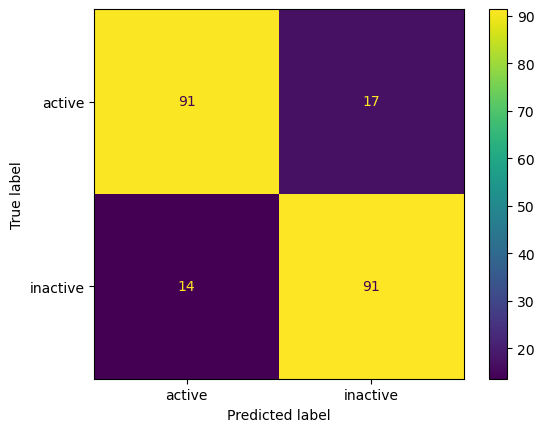

In [10]:
display = ConfusionMatrixDisplay(cm, display_labels=["active", "inactive"])
display.plot()

### Run pipeline

lin2 mobilenetv2_100
Lin2(
  (fc1): Linear(in_features=1280, out_features=1000, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 7.429365694522858, Accuracy = 65.308804%
Validation Epoch 0: Loss = 2.368929862976074, Accuracy = 74.022989%
Training Epoch 1: Loss = 4.586083292961121, Accuracy = 72.996058%
Validation Epoch 1: Loss = 1.4806946516036987, Accuracy = 77.471264%
Training Epoch 2: Loss = 3.936075508594513, Accuracy = 74.835742%
Validation Epoch 2: Loss = 1.1368498802185059, Accuracy = 79.770115%
Training Epoch 3: Loss = 3.5987173914909363, Accuracy = 78.515112%
Validation Epoch 3: Loss = 1.105657696723938, Accuracy = 79.770115%
Training Epoch 4: Loss = 3.4665424823760986, Accuracy = 80.749014%
Validation Epoch 4: Loss = 1.1060869693756104, Accuracy = 81.839080%
Training Epoch 5: Loss = 3.4798792600631714, Accuracy = 80.814717%
Validation Epoch 5: Loss = 1.173401951789856, Accuracy = 80.229885%
Training Epoch 6: Loss = 3.3697738647460938, Accuracy = 78.449409%
Validation Epoch 6: Loss = 1.1581777334213257, Accuracy = 80.919540%
Training Epoch 7: Loss = 3.501242756843567, Accuracy =

test/accuracy,▁
train/accuracy,▁▄▅▆▇▇▆▆▇▇▇█▇▇▇▇██▇█
train/loss,█▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▃▅▅▇▅▆▆▆▅▅▇▆█▆▆▇▆▇▅
validation/loss,█▃▁▁▁▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁
test/accuracy,0.85446
train/accuracy,0.82194
train/loss,3.14837
validation/accuracy,0.8023
validation/loss,1.10129


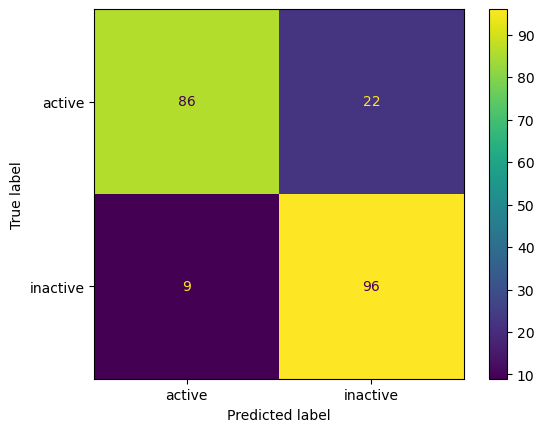

In [12]:
model_pipeline('mobilenetv2_100-sc2000', config_dict)

# DenseNet121 + 2 fully connected layers

### Hyperparameter configuration

In [8]:
config_dict = dict(
    learning_rate = 0.006,
    epochs = 20,
    batch_size = 200,
    feat_extractor = "densenet121",
    fc_model = "lin3",
    normalize = "ImageNet",
    fc2_in = 800,
    fc3_in = 250,
    output = 2,
    dropout_rate = 0.5,
    dataset = "SC-2000v2",
    train_aug = True,
    device = "mps",
    save_as = 'pth'
)

### Average confusion matrix results across 5 runs

In [9]:
cm = ensemble('densenet121-sc2000', config_dict, 5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: livsworld (shenderm). Use `wandb login --relogin` to force relogin


lin3 densenet121
Lin3(
  (fc1): Linear(in_features=1024, out_features=800, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=800, out_features=250, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=250, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 28.088868379592896, Accuracy = 53.613666%
Validation Epoch 0: Loss = 2.074838399887085, Accuracy = 60.689655%
Training Epoch 1: Loss = 4.698502242565155, Accuracy = 65.768725%
Validation Epoch 1: Loss = 1.249506950378418, Accuracy = 77.471264%
Training Epoch 2: Loss = 4.304359942674637, Accuracy = 73.850197%
Validation Epoch 2: Loss = 1.258108139038086, Accuracy = 77.471264%
Training Epoch 3: Loss = 4.154320567846298, Accuracy = 73.653088%
Validation Epoch 3: Loss = 1.2223272323608398, Accuracy = 81.609195%
Training Epoch 4: Loss = 3.930203139781952, Accuracy = 74.901445%
Validation Epoch 4: Loss = 1.1191258430480957, Accuracy = 80.229885%
Training Epoch 5: Loss = 3.7156287729740143, Accuracy = 78.055191%
Validation Epoch 5: Loss = 1.122705340385437, Accuracy = 81.609195%
Training Epoch 6: Loss = 3.77040696144104, Accuracy = 76.675427%
Validation Epoch 6: Loss = 1.1616677045822144, Accuracy = 79.080460%
Training Epoch 7: Loss = 4.06233873963356, Accuracy = 74.3

test/accuracy,▁
train/accuracy,▁▄▇▇▇█▇▇▇▇▇▇▇▇███▇▇█
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▆▆█▇█▇█▇█▇█▇▇██▇▇▆▇
validation/loss,█▂▂▂▁▁▁▂▃▂▁▂▁▂▁▁▂▂▂▂
test/accuracy,0.82629
train/accuracy,0.77267
train/loss,3.63124
validation/accuracy,0.8
validation/loss,1.19557


lin3 densenet121
Lin3(
  (fc1): Linear(in_features=1024, out_features=800, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=800, out_features=250, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=250, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 26.044522643089294, Accuracy = 52.036794%
Validation Epoch 0: Loss = 2.524813175201416, Accuracy = 49.885057%
Training Epoch 1: Loss = 5.124683141708374, Accuracy = 58.212878%
Validation Epoch 1: Loss = 1.4895436763763428, Accuracy = 72.873563%
Training Epoch 2: Loss = 4.6114397048950195, Accuracy = 67.345598%
Validation Epoch 2: Loss = 1.2842094898223877, Accuracy = 79.770115%
Training Epoch 3: Loss = 4.3047332763671875, Accuracy = 72.141919%
Validation Epoch 3: Loss = 1.2990522384643555, Accuracy = 79.310345%
Training Epoch 4: Loss = 4.409184813499451, Accuracy = 71.879106%
Validation Epoch 4: Loss = 1.3102056980133057, Accuracy = 78.160920%
Training Epoch 5: Loss = 4.107356995344162, Accuracy = 73.915900%
Validation Epoch 5: Loss = 1.315380334854126, Accuracy = 77.701149%
Training Epoch 6: Loss = 4.056035488843918, Accuracy = 73.587385%
Validation Epoch 6: Loss = 1.1204164028167725, Accuracy = 81.839080%
Training Epoch 7: Loss = 4.018552333116531, Accuracy =

test/accuracy,▁
train/accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▆█▇▇▇███▇▇███████▇█
validation/loss,█▃▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁
test/accuracy,0.84038
train/accuracy,0.75821
train/loss,3.76193
validation/accuracy,0.8023
validation/loss,1.21293


lin3 densenet121
Lin3(
  (fc1): Linear(in_features=1024, out_features=800, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=800, out_features=250, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=250, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 31.29031264781952, Accuracy = 51.248357%
Validation Epoch 0: Loss = 3.457230567932129, Accuracy = 49.885057%
Training Epoch 1: Loss = 5.290590405464172, Accuracy = 60.315375%
Validation Epoch 1: Loss = 1.3366992473602295, Accuracy = 77.011494%
Training Epoch 2: Loss = 4.3164529502391815, Accuracy = 72.470434%
Validation Epoch 2: Loss = 1.214404582977295, Accuracy = 78.850575%
Training Epoch 3: Loss = 4.240323752164841, Accuracy = 73.324573%
Validation Epoch 3: Loss = 1.180114984512329, Accuracy = 79.770115%
Training Epoch 4: Loss = 4.138354420661926, Accuracy = 73.193167%
Validation Epoch 4: Loss = 1.1372910737991333, Accuracy = 80.689655%
Training Epoch 5: Loss = 3.8966160118579865, Accuracy = 75.755585%
Validation Epoch 5: Loss = 1.0902878046035767, Accuracy = 80.229885%
Training Epoch 6: Loss = 3.8740942776203156, Accuracy = 74.901445%
Validation Epoch 6: Loss = 1.1909476518630981, Accuracy = 81.839080%
Training Epoch 7: Loss = 3.793024718761444, Accuracy = 

test/accuracy,▁
train/accuracy,▁▃▆▇▇▇▇█████▇███████
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▇▇▇█▇██▇▇▇█▇███▇█▇█
validation/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
test/accuracy,0.84038
train/accuracy,0.77595
train/loss,3.61159
validation/accuracy,0.82989
validation/loss,1.12527


lin3 densenet121
Lin3(
  (fc1): Linear(in_features=1024, out_features=800, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=800, out_features=250, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=250, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 24.86120331287384, Accuracy = 54.467806%
Validation Epoch 0: Loss = 1.5308506488800049, Accuracy = 62.068966%
Training Epoch 1: Loss = 4.546372443437576, Accuracy = 67.936925%
Validation Epoch 1: Loss = 1.2543803453445435, Accuracy = 80.459770%
Training Epoch 2: Loss = 4.476090431213379, Accuracy = 69.710907%
Validation Epoch 2: Loss = 1.2471455335617065, Accuracy = 79.310345%
Training Epoch 3: Loss = 4.116418153047562, Accuracy = 74.310118%
Validation Epoch 3: Loss = 1.1769628524780273, Accuracy = 78.390805%
Training Epoch 4: Loss = 3.8676218688488007, Accuracy = 76.478318%
Validation Epoch 4: Loss = 1.1450992822647095, Accuracy = 79.080460%
Training Epoch 5: Loss = 3.920190691947937, Accuracy = 76.675427%
Validation Epoch 5: Loss = 1.1355140209197998, Accuracy = 78.390805%
Training Epoch 6: Loss = 3.822999119758606, Accuracy = 76.806833%
Validation Epoch 6: Loss = 1.1072924137115479, Accuracy = 79.310345%
Training Epoch 7: Loss = 3.678197294473648, Accuracy =

test/accuracy,▁
train/accuracy,▁▅▅▆▇▇▇▇▇▇▇███▇█▇███
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁█▇▇▇▇▇█████████▇▇█▇
validation/loss,█▄▄▃▂▂▂▁▃▃▁▁▁▂▂▄▃▄▂▂
test/accuracy,0.84507
train/accuracy,0.80223
train/loss,3.45106
validation/accuracy,0.8
validation/loss,1.11106


lin3 densenet121
Lin3(
  (fc1): Linear(in_features=1024, out_features=800, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=800, out_features=250, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=250, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 31.623957455158234, Accuracy = 56.241787%
Validation Epoch 0: Loss = 1.8530082702636719, Accuracy = 68.505747%
Training Epoch 1: Loss = 4.817072153091431, Accuracy = 64.126150%
Validation Epoch 1: Loss = 1.397447109222412, Accuracy = 75.402299%
Training Epoch 2: Loss = 4.306898474693298, Accuracy = 72.930355%
Validation Epoch 2: Loss = 1.2615514993667603, Accuracy = 80.919540%
Training Epoch 3: Loss = 4.052775204181671, Accuracy = 76.084100%
Validation Epoch 3: Loss = 1.2923086881637573, Accuracy = 80.229885%
Training Epoch 4: Loss = 3.918063461780548, Accuracy = 76.675427%
Validation Epoch 4: Loss = 1.3895180225372314, Accuracy = 78.850575%
Training Epoch 5: Loss = 3.9693031013011932, Accuracy = 75.624179%
Validation Epoch 5: Loss = 1.2126030921936035, Accuracy = 79.770115%
Training Epoch 6: Loss = 3.8584741055965424, Accuracy = 75.952694%
Validation Epoch 6: Loss = 1.2957121133804321, Accuracy = 79.310345%
Training Epoch 7: Loss = 3.838997930288315, Accuracy 

test/accuracy,▁
train/accuracy,▁▃▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▅▇▇▆▇▇▇▇▇███▇▇██▇▆█
validation/loss,█▄▂▃▄▂▃▂▂▁▁▁▂▁▁▁▁▁▂▁
test/accuracy,0.83568
train/accuracy,0.77201
train/loss,3.74057
validation/accuracy,0.81379
validation/loss,1.1752


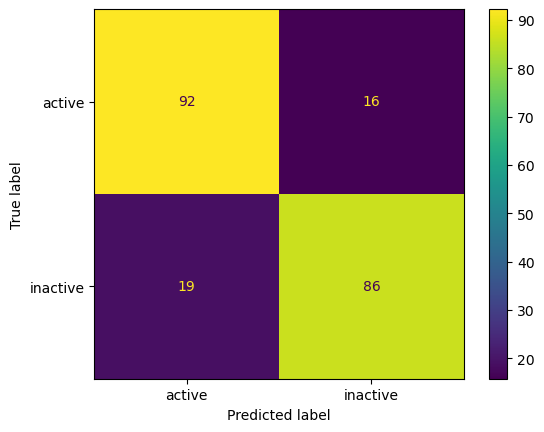

In [10]:
display = ConfusionMatrixDisplay(cm, display_labels=["active", "inactive"])
display.plot()

### Run pipeline

lin3 densenet121
Lin3(
  (fc1): Linear(in_features=1024, out_features=800, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=800, out_features=250, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=250, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 0: Loss = 34.932667315006256, Accuracy = 54.993430%
Validation Epoch 0: Loss = 1.501457929611206, Accuracy = 64.367816%
Training Epoch 1: Loss = 4.608759820461273, Accuracy = 66.228647%
Validation Epoch 1: Loss = 1.2101037502288818, Accuracy = 76.551724%
Training Epoch 2: Loss = 4.249011605978012, Accuracy = 72.404731%
Validation Epoch 2: Loss = 1.1895195245742798, Accuracy = 80.919540%
Training Epoch 3: Loss = 3.9838072061538696, Accuracy = 75.098555%
Validation Epoch 3: Loss = 1.1930688619613647, Accuracy = 78.160920%
Training Epoch 4: Loss = 4.105646252632141, Accuracy = 73.981603%
Validation Epoch 4: Loss = 1.1428520679473877, Accuracy = 80.000000%
Training Epoch 5: Loss = 3.932956874370575, Accuracy = 75.821288%
Validation Epoch 5: Loss = 1.2020267248153687, Accuracy = 81.379310%
Training Epoch 6: Loss = 3.909895747900009, Accuracy = 75.624179%
Validation Epoch 6: Loss = 1.2420027256011963, Accuracy = 80.000000%
Training Epoch 7: Loss = 3.9740277230739594, Accuracy 

test/accuracy,▁
train/accuracy,▁▄▆▇▇▇▇▇▇▇█▇███▇████
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▆█▇▇█▇▇▇▇▆▇█▇█▇▆█▇▇
validation/loss,█▃▂▃▂▃▃▅▃▃▁▂▂▄▁▁▂▃▄▂
test/accuracy,0.83099
train/accuracy,0.77989
train/loss,3.65445
validation/accuracy,0.7977
validation/loss,1.1705


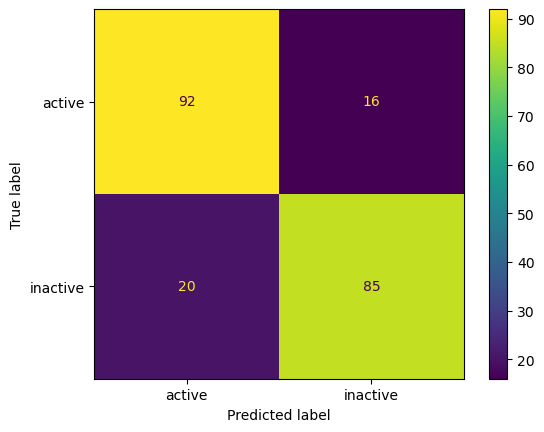

In [14]:
model_pipeline('densenet121-sc2000', config_dict)

# Sweep

**[To Create a New Sweep](https://docs.wandb.ai/ref/cli/wandb-sweep)**

``wandb sweep -p projectname sweep_configs/config.yaml``

In [ ]:
def sweep_pipeline(config=None):
    with wandb.init(config=config):
        config = wandb.config

        model, feat_extractor, train_loader, valid_loader, test_loader, criterion, optimizer = make(config)

        # and use them to train the model
        train(model, feat_extractor, train_loader, valid_loader, criterion, optimizer, config)

        # and test its final performance
        test(model, feat_extractor, test_loader, config)

    return model

Replace with the desired sweep and project

In [ ]:
sweep_id = 'your-id-here'
project = 'resnet50d-sc2000'

In [ ]:
wandb.agent(sweep_id, sweep_pipeline, count=12, project=project)
wandb.teardown()